## Image Captioning
- Generating Caption for Images

## Steps

- Data Collection
-Understanding the Data
-Data Cleaning
-Loading the Training Set
- Data Preprocessing - images
- Data Preprocessing - captions
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import re
import nltk
nltk.download('stopwords')
import string
import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from nltk.corpus import stopwords
from time import time
import pickle

In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

In [5]:
## Read Text File

def readTextFile(path):

  with open(path) as f:
    captions = f.read()

  return captions

In [6]:
captions = readTextFile("/content/drive/MyDrive/Image Captioning Project/Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [7]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [8]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [9]:
captions[0].split("\t")

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [10]:
# Dictionary to map each image with caption it has 

descriptions = {}

for x in captions:
  first,second = x.split("\t")
  img_name = first.split(".")[0]

  if descriptions.get(img_name) is None:
    descriptions[img_name] = []

  descriptions[img_name].append(second)

In [11]:
 descriptions['1002674143_1b742ab4b8']

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

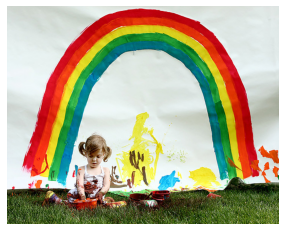

In [12]:
IMG_PATH = "/content/drive/MyDrive/Image Captioning Project/Data/Images/"

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+'1002674143_1b742ab4b8.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## Data Cleaning 

In [13]:
 def clean_text(sentence):
   sentence = sentence.lower()
   sentence = re.sub("[^a-z]"," ",sentence)
   sentence = sentence.split()

   sentence = [s for s in sentence if len(s)>1]
   sentence = " ".join(sentence)

   return sentence

In [14]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [15]:
## Clean all the captions

for key,caption_list in descriptions.items():
  for i in range(len(caption_list)):
    caption_list[i] = clean_text(caption_list[i])

In [16]:
## Write the data to text file
f = open("Descriptions.txt",'w')
f.write(str(descriptions))
f.close()

In [17]:
!mv  "/content/Descriptions.txt" "/content/drive/MyDrive/Image Captioning Project/"

## Vocabulary 

In [18]:
descriptions = None

with open("/content/drive/MyDrive/Image Captioning Project/Descriptions.txt",'r') as f:
  descriptions = f.read()

descriptions = json.loads(descriptions.replace("'", "\""))

In [19]:
type(descriptions)

dict

In [20]:
vocab = set()

for sent_list in list(descriptions.values()):
  for sent in sent_list:
    vocab.update(sent.split())

In [21]:
print(len(vocab))

8424


In [22]:
## Total No of words across all the sentences

total_words = []

for key in descriptions.keys():
  [total_words.append(word) for sent in descriptions[key] for word in sent.split()]



In [23]:
print("Total Words",len(total_words))

Total Words 373837


In [24]:
total_words.count("the")

18420

In [25]:
# Filter words from the vocab according to certain Threshold frequency

import collections
counter = collections.Counter(total_words)
freq_count = dict(counter)
print(len(freq_count))

8424


In [26]:
sorted_freq_count = sorted(freq_count.items(),reverse = True,key = lambda x: x[1])

##Filter
threshold = 10
sorted_freq_count = [x for x in sorted_freq_count if x[1]>threshold]

total_words = [x[0] for x in sorted_freq_count]

In [27]:
print(len(total_words))

1845


## Prepare train/Test Data 

In [28]:
train_file_data = readTextFile("/content/drive/MyDrive/Image Captioning Project/Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/MyDrive/Image Captioning Project/Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [29]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [30]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [31]:
# Prepare Description for the Training Data
# Add <s> and <e> token to our training data

train_descriptions = {}

for img_id in train:
  train_descriptions[img_id] = []

  for cap in descriptions[img_id]:
    cap_to_append = "startseq " + cap + " endseq"
    train_descriptions[img_id].append(cap_to_append)

In [32]:
train_descriptions['1002674143_1b742ab4b8']

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

## transfer Learning

- Images --> features
- Text --> features

### Step - 1: Image Feature Extraction 

In [33]:
model = ResNet50(weights = 'imagenet',input_shape = (224,224,3))
model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [34]:
model_new = Model(model.input,model.layers[-2].output)


In [35]:
def preprocess_img(img):
  img = image.load_img(img,target_size = (224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)

  #Normalization
  img = preprocess_input(img)
  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


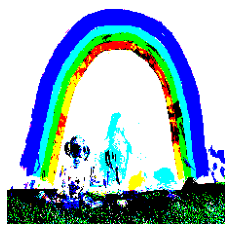

In [36]:
img = preprocess_img(IMG_PATH+'1002674143_1b742ab4b8.jpg')
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [37]:
img.shape

(1, 224, 224, 3)

In [38]:
def encode_image(img):

  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape((-1,))

  return feature_vector

In [39]:
encode_image(IMG_PATH+'1002674143_1b742ab4b8.jpg')

array([0.08411202, 0.61381054, 0.20675702, ..., 0.        , 3.0910556 ,
       1.5624399 ], dtype=float32)

In [ ]:
start = time()

encoding_train = {}

for ix,img_id in enumerate(train):
  img_path = IMG_PATH + img_id + ".jpg"
  encoding_train[img_id] = encode_image(img_path)

  if ix%100 == 0:
    print("Encoding in Progress Time step ",ix)

end = time()

print("Total time taken:",end-start)

In [ ]:
## Store everything to the disk

with open("encoding_train_features.pkl",'wb') as f:
  pickle.dump(encoding_train,f)

In [ ]:
start = time()

encoding_test = {}

for ix,img_id in enumerate(test):
  img_path = IMG_PATH + img_id + ".jpg"
  encoding_test[img_id] = encode_image(img_path)

  if ix%100 == 0:
    print("Encoding in Progress Time step ",ix)

end = time()

print("Total time taken:",end-start)

In [ ]:
## Store everything to the disk

with open("encoding_test_features.pkl",'wb') as f:
  pickle.dump(encoding_test,f)

In [ ]:
!mv "/content/encoding_train_features.pkl" "/content/drive/MyDrive/Image Captioning Project/"

In [ ]:
!mv "/content/encoding_test_features.pkl" "/content/drive/MyDrive/Image Captioning Project/"

In [41]:
with open("/content/drive/MyDrive/Image Captioning Project/encoding_train_features.pkl",'rb') as f:
  encoding_train = pickle.load(f)

In [42]:
with open("/content/drive/MyDrive/Image Captioning Project/encoding_test_features.pkl",'rb') as f:
  encoding_test = pickle.load(f)

## Data Preprocessing - Captions

In [43]:
len(total_words)

1845

In [44]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
  word_to_idx[word] = i+1
  idx_to_word[i+1] = word


In [45]:
idx_to_word[1]

'in'

In [46]:
len(word_to_idx)

1845

In [47]:
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [48]:
len(word_to_idx)

1847

In [49]:
vocab_size = len(word_to_idx)+1
print("Vocab_Size: ",vocab_size)

Vocab_Size:  1848


In [50]:
max_len = 0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    if len(cap.split())> max_len:
      max_len = len(cap.split())

In [51]:
print(max_len)

35


## Data Loader (Generator)

In [52]:

def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]    #photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

## Word Embeddings 

In [75]:
f = open("/content/drive/MyDrive/Image Captioning Project/glove.6B.50d.txt",encoding = 'utf8')

embedding_index = {}

for line in f:
  values = line.split()
  
  word = values[0]
  word_embedding = np.array(values[1:],dtype = 'float')
  embedding_index[word] = word_embedding

f.close()

embedding_index['word']

array([-0.1643   ,  0.15722  , -0.55021  , -0.3303   ,  0.66463  ,
       -0.1152   , -0.2261   , -0.23674  , -0.86119  ,  0.24319  ,
        0.074499 ,  0.61081  ,  0.73683  , -0.35224  ,  0.61346  ,
        0.0050975, -0.62538  , -0.0050458,  0.18392  , -0.12214  ,
       -0.65973  , -0.30673  ,  0.35038  ,  0.75805  ,  1.0183   ,
       -1.7424   , -1.4277   ,  0.38032  ,  0.37713  , -0.74941  ,
        2.9401   , -0.8097   , -0.66901  ,  0.23123  , -0.073194 ,
       -0.13624  ,  0.24424  , -1.0129   , -0.24919  , -0.06893  ,
        0.70231  , -0.022177 , -0.64684  ,  0.59599  ,  0.027092 ,
        0.11203  ,  0.61214  ,  0.74339  ,  0.23572  , -0.1369   ])

In [76]:
def get_embedding_matrix():
  emb_dim = 50
  matrix = np.zeros((vocab_size,emb_dim))

  for word,idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
      matrix[idx] = embedding_vector

  return matrix


In [77]:
embedding_matrix = get_embedding_matrix()

## Model Architecture 

In [78]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation = 'relu')(inp_img1)

In [79]:
#Captions as input

input_captions = Input(shape = (max_len,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim = 50,mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [80]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model
model = Model(inputs = [input_img_features,input_captions],outputs = outputs)

In [81]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [82]:
# Preinitialize Embedding Layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [83]:
model.compile(loss = 'categorical_crossentropy',optimizer='adam')

## Training of Model 

In [84]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

In [85]:
def train():
  for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save("/content/drive/MyDrive/Image Captioning Project/model_weights/model_"+str(i)+'.h5')

In [86]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [87]:
train()

   3/2000 [..............................] - ETA: 1:14 - loss: 7.3782

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


   1/2000 [..............................] - ETA: 1:29 - loss: 3.1026

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 73s 37ms/step - loss: 2.4753


## Predictions 

In [88]:
model = load_model("/content/drive/MyDrive/Image Captioning Project/model_weights/model_29.h5")

In [89]:

def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [90]:
IMG_PATH

'/content/drive/MyDrive/Image Captioning Project/Data/Images/'

In [92]:
 ##Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
/content/drive/MyDrive/Image Captioning Project/model_weights